Phase 3: Basic Traffic Flow Prediction

In [22]:
# Import Statements
from sklearn.linear_model import LinearRegression
from sklearn.metrics import mean_absolute_error, mean_squared_error
import pandas as pd
import numpy as np
import gzip
import json
from kafka import KafkaProducer, KafkaConsumer
import matplotlib.pyplot as plt
from statsmodels.tsa.arima.model import ARIMA
import scipy.io

In [24]:
# ---------------------------
# 1. Load the training and testing data from .mat files
# ---------------------------
mat = scipy.io.loadmat('/Users/ayushtripathi/94879/traffic+flow+forecasting/traffic_dataset.mat')

# Extract training and testing data
tra_X_tr = mat['tra_X_tr']
tra_Y_tr = mat['tra_Y_tr']
tra_X_te = mat['tra_X_te']
tra_Y_te = mat['tra_Y_te']

# Convert data to pandas DataFrame for easier manipulation
df_tra_X_tr = pd.DataFrame(tra_X_tr[0][0].toarray())  # Convert sparse matrix to dense for training data
df_tra_Y_tr = pd.DataFrame(tra_Y_tr)
df_tra_X_te = pd.DataFrame(tra_X_te[0][0].toarray())  # Convert sparse matrix to dense for testing data
df_tra_Y_te = pd.DataFrame(tra_Y_te)

In [27]:
# ---------------------------------------------------
# 2. Feature Engineering (Time-based features, Rolling Statistics)
# ---------------------------------------------------
rolling_window_size = 4  # Rolling average over 1 hour (4 intervals)

# Time-based features
df_tra_X_tr['hour_of_day'] = np.arange(len(df_tra_X_tr)) % 24  # Feature for hour of the day
df_tra_X_tr['day_of_week'] = np.arange(len(df_tra_X_tr)) % 7  # Feature for day of the week

# Rolling statistics
df_tra_X_tr['rolling_mean'] = df_tra_X_tr.iloc[:, 0].rolling(window=rolling_window_size).mean()
df_tra_X_tr['rolling_std'] = df_tra_X_tr.iloc[:, 0].rolling(window=rolling_window_size).std()

# Fill any NaN values resulting from rolling operations
df_tra_X_tr.fillna(method='bfill', inplace=True)

# Applying the same feature engineering steps to the testing data
df_tra_X_te['hour_of_day'] = np.arange(len(df_tra_X_te)) % 24
df_tra_X_te['day_of_week'] = np.arange(len(df_tra_X_te)) % 7
df_tra_X_te['rolling_mean'] = df_tra_X_te.iloc[:, 0].rolling(window=rolling_window_size).mean()
df_tra_X_te['rolling_std'] = df_tra_X_te.iloc[:, 0].rolling(window=rolling_window_size).std()
df_tra_X_te.fillna(method='bfill', inplace=True)

/var/folders/_g/8y41f5w13qb2kb1833r_2qlc0000gn/T/ipykernel_32686/1946326140.py:15: FutureWarning: DataFrame.fillna with 'method' is deprecated and will raise in a future version. Use obj.ffill() or obj.bfill() instead.
  df_tra_X_tr.fillna(method='bfill', inplace=True)
/var/folders/_g/8y41f5w13qb2kb1833r_2qlc0000gn/T/ipykernel_32686/1946326140.py:22: FutureWarning: DataFrame.fillna with 'method' is deprecated and will raise in a future version. Use obj.ffill() or obj.bfill() instead.
  df_tra_X_te.fillna(method='bfill', inplace=True)


Simple Regression Model:

Testing MAE: 0.3584538462431641
Testing RMSE: 0.4171353958242547


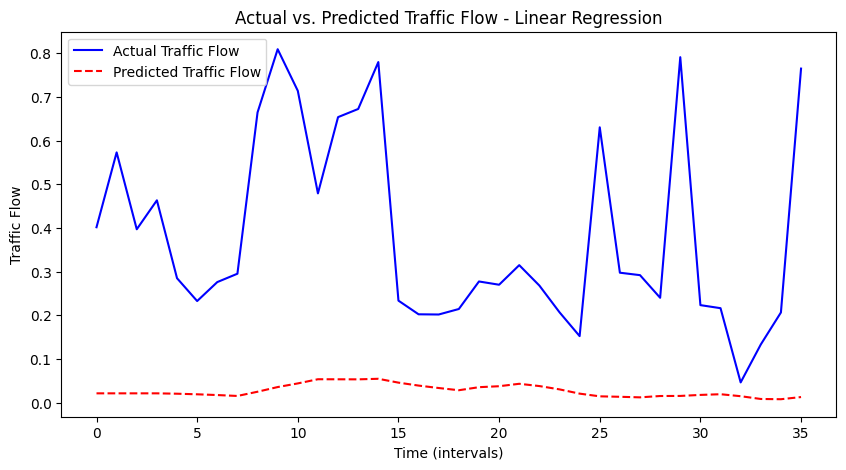

In [29]:
# ---------------------------------------------------
# 3. Train Simple Regression Model (just as a baseline)
# ---------------------------------------------------
# Prepare feature matrix for training
X_train = df_tra_X_tr[['rolling_mean']]
y_train = df_tra_Y_tr.iloc[:, 0].values  # Target variable (first column of tra_Y_tr)

# Initialize and train the model
model = LinearRegression()
model.fit(X_train, y_train)

# Predict on testing data
X_test = df_tra_X_te[['rolling_mean']]
y_test = df_tra_Y_te.iloc[:, 0].values

# Evaluate the model
y_test_pred = model.predict(X_test)
test_mae = mean_absolute_error(y_test, y_test_pred)
test_rmse = np.sqrt(mean_squared_error(y_test, y_test_pred))
print("Simple Regression Model:\n")
print(f"Testing MAE: {test_mae}")
print(f"Testing RMSE: {test_rmse}")

# Plot Actual vs. Predicted Values for Linear Regression
plt.figure(figsize=(10, 5))
plt.plot(y_test, label='Actual Traffic Flow', color='blue')
plt.plot(y_test_pred, label='Predicted Traffic Flow', color='red', linestyle='--')
plt.title('Actual vs. Predicted Traffic Flow - Linear Regression')
plt.xlabel('Time (intervals)')
plt.ylabel('Traffic Flow')
plt.legend()
plt.show()

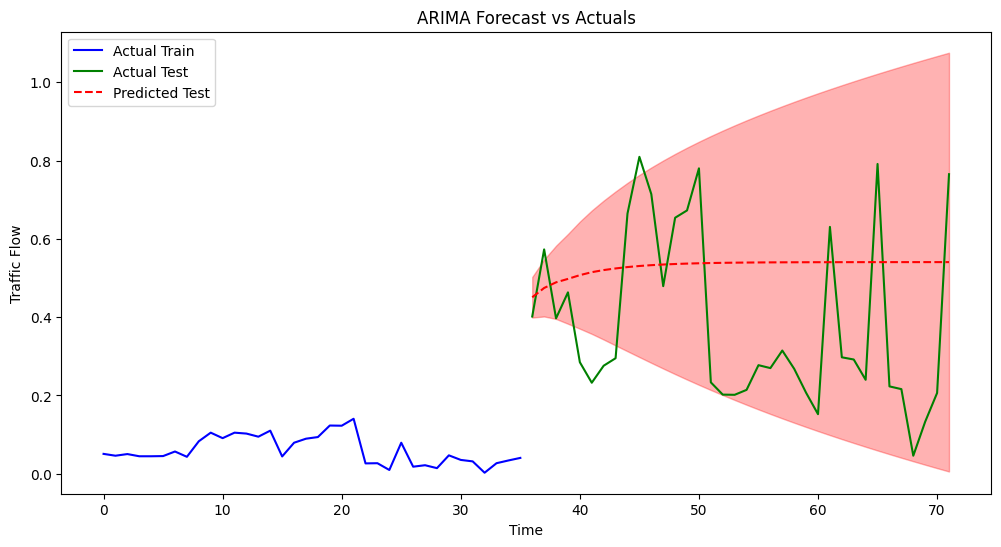

ARIMA Test MAE:  0.2413990795112425
ARIMA Test RMSE:  0.2635707627208213


In [30]:
# ---------------------------------------------------
# 4. Train ARIMA Model
# ---------------------------------------------------

# Calculate the number of test data points
num_test_points = len(df_tra_Y_te.iloc[:, 0])  # Assuming df_tra_Y_te is already defined and correct

# Predict using ARIMA over the training + testing period
# Extend the forecast to cover the testing period
arima_forecast = model_arima_fit.get_forecast(steps=num_test_points)
forecast_conf_int = arima_forecast.conf_int()
forecast_mean = arima_forecast.predicted_mean

# Plot the ARIMA forecast and the actual values
plt.figure(figsize=(12, 6))
plt.plot(df_tra_Y_tr.iloc[:, 0], label='Actual Train', color='blue')  # Train data
plt.plot(np.arange(len(df_tra_Y_tr.iloc[:, 0]), len(df_tra_Y_tr.iloc[:, 0]) + num_test_points), df_tra_Y_te.iloc[:, 0], label='Actual Test', color='green')  # Actual test data
plt.plot(np.arange(len(df_tra_Y_tr.iloc[:, 0]), len(df_tra_Y_tr.iloc[:, 0]) + num_test_points), forecast_mean, label='Predicted Test', color='red', linestyle='--')  # Forecast on test data
plt.fill_between(np.arange(len(df_tra_Y_tr.iloc[:, 0]), len(df_tra_Y_tr.iloc[:, 0]) + num_test_points), forecast_conf_int[:, 0], forecast_conf_int[:, 1], color='red', alpha=0.3)
plt.title('ARIMA Forecast vs Actuals')
plt.xlabel('Time')
plt.ylabel('Traffic Flow')
plt.legend()
plt.show()

# Calculate MAE and RMSE for the test period
test_mae = mean_absolute_error(df_tra_Y_te.iloc[:, 0].values, forecast_mean)
test_rmse = np.sqrt(mean_squared_error(df_tra_Y_te.iloc[:, 0].values, forecast_mean))
print("ARIMA Test MAE: ", test_mae)
print("ARIMA Test RMSE: ", test_rmse)


In [31]:
# -------------------------------------------
# 5. Kafka Producer for Real-Time Data Streaming
# -------------------------------------------
# Initialize Kafka Producer
producer = KafkaProducer(bootstrap_servers='localhost:9092', value_serializer=lambda v: json.dumps(v).encode('utf-8'))

# Send the feature data to Kafka topic 'traffic_features'
for index, row in df_tra_X_tr.iterrows():
    data = row.to_dict()
    producer.send('traffic_features', data)
    print(f"Sent data for index {index}")

producer.flush()
producer.close()

# --------------------------------------------
# 6. Kafka Consumer for Real-Time Prediction
# --------------------------------------------
# Initialize Kafka Consumer
consumer = KafkaConsumer(
    'traffic_features', 
    bootstrap_servers='localhost:9092', 
    value_deserializer=lambda x: json.loads(x.decode('utf-8')),
    group_id='my-consumer-group',  # Ensure unique consumer group
    auto_offset_reset='earliest'  # Start from the beginning of the topic
)

print("Waiting for messages from Kafka...")

# Predict traffic flow in real-time using the ARIMA model
for message in consumer:
    try:
        data = message.value
        # Extract the relevant features for real-time prediction
        last_known_value = data['rolling_mean']
        
        # Predict the next value using the ARIMA model
        # ARIMA forecasting assumes continuation of the series, so for real-time prediction, we need to appropriately manage state or re-fit the model as new data comes in.
        prediction = model_arima_fit.forecast(steps=1)
        
        print(f"Predicted Traffic Flow: {prediction[0]}")  # Output predicted traffic flow
    except Exception as e:
        print(f"Error processing message: {e}")

consumer.close()

Sent data for index 0
Sent data for index 1
Sent data for index 2
Sent data for index 3
Sent data for index 4
Sent data for index 5
Sent data for index 6
Sent data for index 7
Sent data for index 8
Sent data for index 9
Sent data for index 10
Sent data for index 11
Sent data for index 12
Sent data for index 13
Sent data for index 14
Sent data for index 15
Sent data for index 16
Sent data for index 17
Sent data for index 18
Sent data for index 19
Sent data for index 20
Sent data for index 21
Sent data for index 22
Sent data for index 23
Sent data for index 24
Sent data for index 25
Sent data for index 26
Sent data for index 27
Sent data for index 28
Sent data for index 29
Sent data for index 30
Sent data for index 31
Sent data for index 32
Sent data for index 33
Sent data for index 34
Sent data for index 35
Waiting for messages from Kafka...
Predicted Traffic Flow: 0.45081528353951644
Predicted Traffic Flow: 0.45081528353951644
Predicted Traffic Flow: 0.45081528353951644
Predicted Traff

KeyboardInterrupt: 

Citations:
starter_noteboook_traffic_flow_prediction.py

(Code provided by the class.)